# Semantic Image Clustering

This example demonstrates how to apply the Semantic Clustering by Adopting Nearest neighbors (SCAN) algorithm (Van Gansbeke et al., 2020) on the CIFAR-10 dataset. The algorithm consists of two phases:

1. Self-supervised visual representation learning of images, in which we use the simCLR technique.
2. Clustering of the learned visual representation vectors to maximize the agreement between the cluster assignments of neighboring vectors.

This will take approximately 2 hours to run.
---






## Setup


In [1]:
# ! pip install tensorflow_addons
from collections import defaultdict
import random
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tqdm import tqdm

## Prepare the data




In [2]:
num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_data = np.concatenate([x_train, x_test])
y_data = np.concatenate([y_train, y_test])

print("x_data shape:", x_data.shape, "- y_data shape:", y_data.shape)

classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]


x_data shape: (60000, 32, 32, 3) - y_data shape: (60000, 1)


### Define hyperparameters


In [3]:
target_size = 32  # Resize the input images.
representation_dim = 512  # The dimensions of the features vector.
projection_units = 128  # The projection head of the representation learner.
num_clusters = 20  # Number of clusters.
k_neighbours = 5  # Number of neighbours to consider during cluster learning.
tune_encoder_during_clustering = False  # Freeze the encoder in the cluster learning.


### Implement data preprocessing


In [4]:
data_preprocessing = keras.Sequential(
    [
        layers.Resizing(target_size, target_size),
        layers.Normalization(),
    ]
)
# Compute the mean and the variance from the data for normalization.
data_preprocessing.layers[-1].adapt(x_data)


### Data augmentation

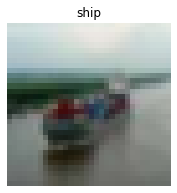

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomTranslation(
            height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode="nearest"
        ),
        layers.RandomFlip(mode="horizontal"),
        layers.RandomRotation(
            factor=0.15, fill_mode="nearest"
        ),
        layers.RandomZoom(
            height_factor=(-0.3, 0.1), width_factor=(-0.3, 0.1), fill_mode="nearest"
        )
    ]
)
image_idx = np.random.choice(range(x_data.shape[0]))
image = x_data[image_idx]
image_class = classes[y_data[image_idx][0]]
plt.figure(figsize=(3, 3))
plt.imshow(x_data[image_idx].astype("uint8"))
plt.title(image_class)
_ = plt.axis("off")


Display a sample of augmented versions of the image

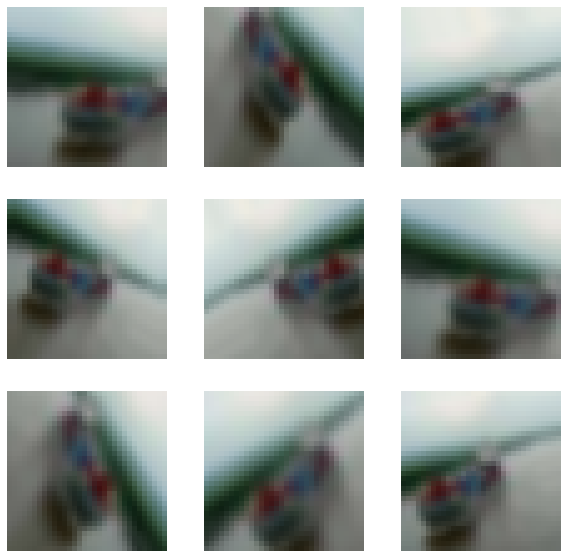

In [6]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_images = data_augmentation(np.array([image]))
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Self-supervised representation learning


In [7]:
## Implement the vision encoder
def create_encoder(representation_dim):
    encoder = keras.Sequential(
        [
            keras.applications.ResNet50V2(
                include_top=False, weights=None, pooling="avg"
            ),
            layers.Dense(representation_dim),
        ]
    )
    return encoder

### Implement the unsupervised contrastive loss
class RepresentationLearner(keras.Model):
    def __init__(
        self,
        encoder,
        projection_units,
        num_augmentations,
        temperature=1.0,
        dropout_rate=0.1,
        l2_normalize=False,
        **kwargs
    ):
        super(RepresentationLearner, self).__init__(**kwargs)
        self.encoder = encoder
        # Create projection head.
        self.projector = keras.Sequential(
            [
                layers.Dropout(dropout_rate),
                layers.Dense(units=projection_units, use_bias=False),
                layers.BatchNormalization(),
                layers.ReLU(),
            ]
        )
        self.num_augmentations = num_augmentations
        self.temperature = temperature
        self.l2_normalize = l2_normalize
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def compute_contrastive_loss(self, feature_vectors, batch_size):
        num_augmentations = tf.shape(feature_vectors)[0] // batch_size
        if self.l2_normalize:
            feature_vectors = tf.math.l2_normalize(feature_vectors, -1)
        # The logits shape is [num_augmentations * batch_size, num_augmentations * batch_size].
        logits = (
            tf.linalg.matmul(feature_vectors, feature_vectors, transpose_b=True)
            / self.temperature
        )
        # Apply log-max trick for numerical stability.
        logits_max = tf.math.reduce_max(logits, axis=1)
        logits = logits - logits_max
        # The shape of targets is [num_augmentations * batch_size, num_augmentations * batch_size].
        # targets is a matrix consits of num_augmentations submatrices of shape [batch_size * batch_size].
        # Each [batch_size * batch_size] submatrix is an identity matrix (diagonal entries are ones).
        targets = tf.tile(tf.eye(batch_size), [num_augmentations, num_augmentations])
        # Compute cross entropy loss
        return keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )

    def call(self, inputs):
        # Preprocess the input images.
        preprocessed = data_preprocessing(inputs)
        # Create augmented versions of the images.
        augmented = []
        for _ in range(self.num_augmentations):
            augmented.append(data_augmentation(preprocessed))
        augmented = layers.Concatenate(axis=0)(augmented)
        # Generate embedding representations of the images.
        features = self.encoder(augmented)
        # Apply projection head.
        return self.projector(features)

    def train_step(self, inputs):
        batch_size = tf.shape(inputs)[0]
        # Run the forward pass and compute the contrastive loss
        with tf.GradientTape() as tape:
            feature_vectors = self(inputs, training=True)
            loss = self.compute_contrastive_loss(feature_vectors, batch_size)
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update loss tracker metric
        self.loss_tracker.update_state(loss)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, inputs):
        batch_size = tf.shape(inputs)[0]
        feature_vectors = self(inputs, training=False)
        loss = self.compute_contrastive_loss(feature_vectors, batch_size)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

### Train the model
# Create vision encoder.
encoder = create_encoder(representation_dim)
# Create representation learner.
representation_learner = RepresentationLearner(
    encoder, projection_units, num_augmentations=2, temperature=0.1
)
# Create a a Cosine decay learning rate scheduler.
lr_scheduler = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001, decay_steps=500, alpha=0.1
)
# Compile the model.
representation_learner.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=lr_scheduler, weight_decay=0.0001),
)
# Fit the model.
history = representation_learner.fit(
    x=x_data,
    batch_size=512,
    epochs=1,  # for better results, increase the number of epochs to 500.
)


118/118 [==============================] - 7219s 61s/step - loss: 29.2500


Plot training loss



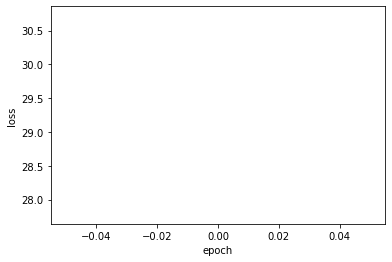

In [8]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()


Generate the embeddings for the images


In [9]:
batch_size = 500
# Get the feature vector representations of the images.
feature_vectors = encoder.predict(x_data, batch_size=batch_size, verbose=1)
# Normalize the feature vectores.
feature_vectors = tf.math.l2_normalize(feature_vectors, -1)


120/120 [==============================] - 155s 1s/step


Find the k nearest neighbours for each embedding

In [10]:
neighbours = []
num_batches = feature_vectors.shape[0] // batch_size
for batch_idx in tqdm(range(num_batches)):
    start_idx = batch_idx * batch_size
    end_idx = start_idx + batch_size
    current_batch = feature_vectors[start_idx:end_idx]
    # Compute the dot similarity.
    similarities = tf.linalg.matmul(current_batch, feature_vectors, transpose_b=True)
    # Get the indices of most similar vectors.
    _, indices = tf.math.top_k(similarities, k=k_neighbours + 1, sorted=True)
    # Add the indices to the neighbours.
    neighbours.append(indices[..., 1:])

neighbours = np.reshape(np.array(neighbours), (-1, k_neighbours))


100%|██████████| 120/120 [01:58<00:00,  1.01it/s]


### Implement clustering consistency loss
This loss tries to make sure that neighbours have the same clustering assignments.



In [11]:
class ClustersConsistencyLoss(keras.losses.Loss):
    def __init__(self):
        super(ClustersConsistencyLoss, self).__init__()

    def __call__(self, target, similarity, sample_weight=None):
        # Set targets to be ones.
        target = tf.ones_like(similarity)
        # Compute cross entropy loss.
        loss = keras.losses.binary_crossentropy(
            y_true=target, y_pred=similarity, from_logits=True
        )
        return tf.math.reduce_mean(loss)


Implement the clusters entropy loss
This loss tries to make sure that cluster distribution is roughly uniformed, to avoid assigning most of the instances to one cluster.

In [12]:
class ClustersEntropyLoss(keras.losses.Loss):
    def __init__(self, entropy_loss_weight=1.0):
        super(ClustersEntropyLoss, self).__init__()
        self.entropy_loss_weight = entropy_loss_weight

    def __call__(self, target, cluster_probabilities, sample_weight=None):
        # Ideal entropy = log(num_clusters).
        num_clusters = tf.cast(tf.shape(cluster_probabilities)[-1], tf.dtypes.float32)
        target = tf.math.log(num_clusters)
        # Compute the overall clusters distribution.
        cluster_probabilities = tf.math.reduce_mean(cluster_probabilities, axis=0)
        # Replacing zero probabilities - if any - with a very small value.
        cluster_probabilities = tf.clip_by_value(
            cluster_probabilities, clip_value_min=1e-8, clip_value_max=1.0
        )
        # Compute the entropy over the clusters.
        entropy = -tf.math.reduce_sum(
            cluster_probabilities * tf.math.log(cluster_probabilities)
        )
        # Compute the difference between the target and the actual.
        loss = target - entropy
        return loss


Implement clustering model
This model takes a raw image as an input, generated its feature vector using the trained encoder, and produces a probability distribution of the clusters given the feature vector as the cluster assignments.



In [13]:
def create_clustering_model(encoder, num_clusters, name=None):
    inputs = keras.Input(shape=input_shape)
    # Preprocess the input images.
    preprocessed = data_preprocessing(inputs)
    # Apply data augmentation to the images.
    augmented = data_augmentation(preprocessed)
    # Generate embedding representations of the images.
    features = encoder(augmented)
    # Assign the images to clusters.
    outputs = layers.Dense(units=num_clusters, activation="softmax")(features)
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    return model


Implement clustering learner
This model receives the input anchor image and its neighbours, produces the clusters assignments for them using the clustering_model, and produces two outputs: 1. similarity: the similarity between the cluster assignments of the anchor image and its neighbours. This output is fed to the ClustersConsistencyLoss. 2. anchor_clustering: cluster assignments of the anchor images. This is fed to the ClustersEntropyLoss.



In [14]:
def create_clustering_learner(clustering_model):
    anchor = keras.Input(shape=input_shape, name="anchors")
    neighbours = keras.Input(
        shape=tuple([k_neighbours]) + input_shape, name="neighbours"
    )
    # Changes neighbours shape to [batch_size * k_neighbours, width, height, channels]
    neighbours_reshaped = tf.reshape(neighbours, shape=tuple([-1]) + input_shape)
    # anchor_clustering shape: [batch_size, num_clusters]
    anchor_clustering = clustering_model(anchor)
    # neighbours_clustering shape: [batch_size * k_neighbours, num_clusters]
    neighbours_clustering = clustering_model(neighbours_reshaped)
    # Convert neighbours_clustering shape to [batch_size, k_neighbours, num_clusters]
    neighbours_clustering = tf.reshape(
        neighbours_clustering,
        shape=(-1, k_neighbours, tf.shape(neighbours_clustering)[-1]),
    )
    # similarity shape: [batch_size, 1, k_neighbours]
    similarity = tf.linalg.einsum(
        "bij,bkj->bik", tf.expand_dims(anchor_clustering, axis=1), neighbours_clustering
    )
    # similarity shape:  [batch_size, k_neighbours]
    similarity = layers.Lambda(lambda x: tf.squeeze(x, axis=1), name="similarity")(
        similarity
    )
    # Create the model.
    model = keras.Model(
        inputs=[anchor, neighbours],
        outputs=[similarity, anchor_clustering],
        name="clustering_learner",
    )
    return model

## Train model

# If tune_encoder_during_clustering is set to False,
# then freeze the encoder weights.
for layer in encoder.layers:
    layer.trainable = tune_encoder_during_clustering
# Create the clustering model and learner.
clustering_model = create_clustering_model(encoder, num_clusters, name="clustering")
clustering_learner = create_clustering_learner(clustering_model)
# Instantiate the model losses.
losses = [ClustersConsistencyLoss(), ClustersEntropyLoss(entropy_loss_weight=5)]
# Create the model inputs and labels.
inputs = {"anchors": x_data, "neighbours": tf.gather(x_data, neighbours)}
labels = tf.ones(shape=(x_data.shape[0]))
# Compile the model.
clustering_learner.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.0005, weight_decay=0.0001),
    loss=losses,
)

# Begin training the model.
clustering_learner.fit(x=inputs, y=labels, batch_size=512, epochs=1)


118/118 [==============================] - 972s 8s/step - loss: 0.6759 - similarity_loss: 0.6681 - clustering_loss: 0.0078


Plot training loss



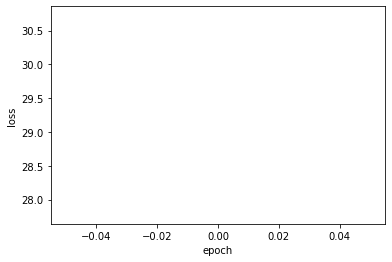

In [15]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()


Cluster analysis
Assign images to clusters


In [16]:
# Get the cluster probability distribution of the input images.
clustering_probs = clustering_model.predict(x_data, batch_size=batch_size, verbose=1)
# Get the cluster of the highest probability.
cluster_assignments = tf.math.argmax(clustering_probs, axis=-1).numpy()
# Store the clustering confidence.
# Images with the highest clustering confidence are considered the 'prototypes'
# of the clusters.
cluster_confidence = tf.math.reduce_max(clustering_probs, axis=-1).numpy()


120/120 [==============================] - 158s 1s/step


Let's compute the cluster sizes



In [17]:
clusters = defaultdict(list)
for idx, c in enumerate(cluster_assignments):
    clusters[c].append((idx, cluster_confidence[idx]))

for c in range(num_clusters):
    print("cluster", c, ":", len(clusters[c]))


cluster 0 : 13702
cluster 1 : 2328
cluster 2 : 2686
cluster 3 : 1420
cluster 4 : 933
cluster 5 : 1730
cluster 6 : 1157
cluster 7 : 6335
cluster 8 : 815
cluster 9 : 6185
cluster 10 : 382
cluster 11 : 1257
cluster 12 : 1410
cluster 13 : 1872
cluster 14 : 1443
cluster 15 : 10131
cluster 16 : 642
cluster 17 : 607
cluster 18 : 2555
cluster 19 : 2410


Notice that the clusters have roughly balanced sizes.

Visualize cluster images
Display the prototypes—instances with the highest clustering confidence—of each cluster:



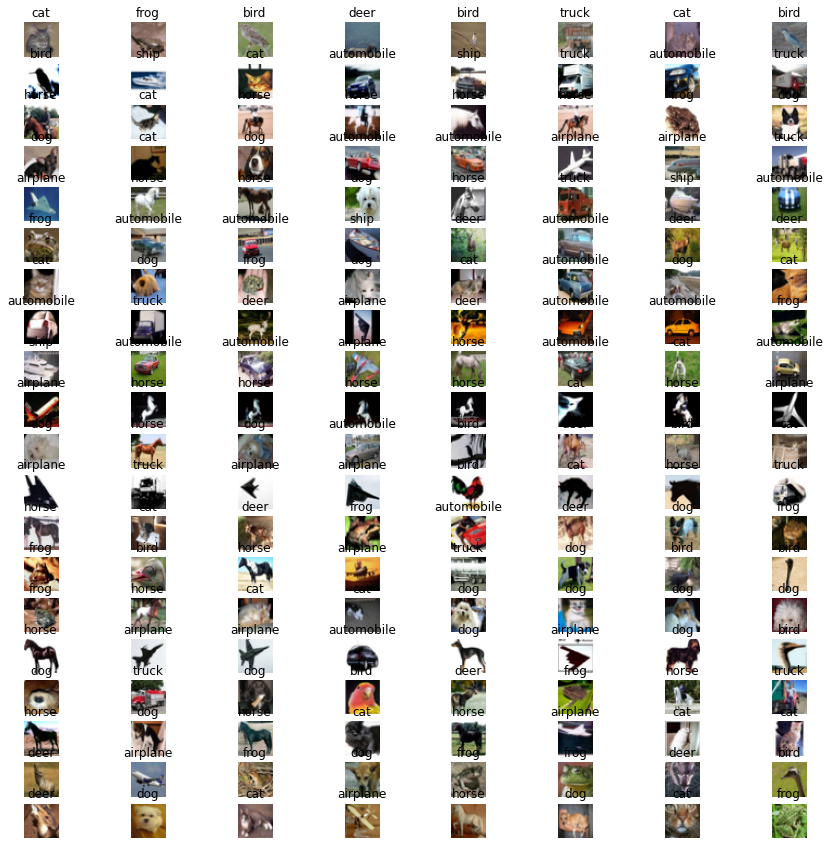

In [18]:
num_images = 8
plt.figure(figsize=(15, 15))
position = 1
for c in range(num_clusters):
    cluster_instances = sorted(clusters[c], key=lambda kv: kv[1], reverse=True)

    for j in range(num_images):
        image_idx = cluster_instances[j][0]
        plt.subplot(num_clusters, num_images, position)
        plt.imshow(x_data[image_idx].astype("uint8"))
        plt.title(classes[y_data[image_idx][0]])
        plt.axis("off")
        position += 1


Compute clustering accuracy
First, we assign a label for each cluster based on the majority label of its images. Then, we compute the accuracy of each cluster by dividing the number of image with the majority label by the size of the cluster.



In [19]:
cluster_label_counts = dict()

for c in range(num_clusters):
    cluster_label_counts[c] = [0] * num_classes
    instances = clusters[c]
    for i, _ in instances:
        cluster_label_counts[c][y_data[i][0]] += 1

    cluster_label_idx = np.argmax(cluster_label_counts[c])
    correct_count = np.max(cluster_label_counts[c])
    cluster_size = len(clusters[c])
    accuracy = (
        np.round((correct_count / cluster_size) * 100, 2) if cluster_size > 0 else 0
    )
    cluster_label = classes[cluster_label_idx]
    print("cluster", c, "label is:", cluster_label, " -  accuracy:", accuracy, "%")


cluster 0 label is: bird  -  accuracy: 16.56 %
cluster 1 label is: truck  -  accuracy: 18.99 %
cluster 2 label is: horse  -  accuracy: 15.9 %
cluster 3 label is: airplane  -  accuracy: 15.99 %
cluster 4 label is: airplane  -  accuracy: 14.79 %
cluster 5 label is: deer  -  accuracy: 15.66 %
cluster 6 label is: cat  -  accuracy: 18.84 %
cluster 7 label is: frog  -  accuracy: 14.73 %
cluster 8 label is: dog  -  accuracy: 17.3 %
cluster 9 label is: dog  -  accuracy: 15.42 %
cluster 10 label is: horse  -  accuracy: 12.83 %
cluster 11 label is: airplane  -  accuracy: 15.51 %
cluster 12 label is: automobile  -  accuracy: 15.32 %
cluster 13 label is: dog  -  accuracy: 12.82 %
cluster 14 label is: dog  -  accuracy: 16.15 %
cluster 15 label is: truck  -  accuracy: 19.79 %
cluster 16 label is: frog  -  accuracy: 15.11 %
cluster 17 label is: horse  -  accuracy: 16.97 %
cluster 18 label is: airplane  -  accuracy: 14.64 %
cluster 19 label is: frog  -  accuracy: 18.46 %


## Acknowledgements
https://keras.io/examples/vision/semantic_image_clustering/